# MONEYBALL EXPLAINED

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

In [2]:
def add_feature(df):
    # 1B stats
    df['1B'] = df['H'] - (df['2B'] + df['3B'] + df.HR)
    # At Bat per Homerun
    df['ABHR'] = round(df['AB'] / df['HR'],3)
    # AVG (H/AB)
    df['AVG'] = round(df['H'] / df['AB'],3)
    # On Base Percentage
    df['OBP'] = round(
        (df.H + df.BB + df.HBP) / 
        (df.AB + df.BB + df.HBP + df.SF),3)
    # Slugging rate
    df['SLG'] = round(
        (df['1B'] + df['2B']*2 + df['3B']*3 + df['HR']*4) / 
        df.AB, 3)
    # OBP Plus SLG
    df['OPS'] = df.OBP + df.SLG


The data is from Lahman's Baseball Database, which you can get access for free on their website.

    -> https://www.seanlahman.com/baseball-archive/statistics/

In [3]:
df_player = pd.read_csv('/Users/jinc/Desktop/프로젝트/baseball_analysis/baseball_analysis/lahman/core/People.csv')
df_salaries = pd.read_csv('/Users/jinc/Desktop/프로젝트/baseball_analysis/baseball_analysis/lahman/contrib/Salaries.csv')
df_batting = pd.read_csv('/Users/jinc/Desktop/프로젝트/baseball_analysis/baseball_analysis/lahman/core/Batting.csv')
df_pitching = pd.read_csv('/Users/jinc/Desktop/프로젝트/baseball_analysis/baseball_analysis/lahman/core/Pitching.csv')
df_team = pd.read_csv('/Users/jinc/Desktop/프로젝트/baseball_analysis/baseball_analysis/lahman/core/Teams.csv')
df_post = pd.read_csv('/Users/jinc/Desktop/프로젝트/baseball_analysis/baseball_analysis/lahman/core/PitchingPost.csv')

In [4]:
df_team.pipe(add_feature)
df_batting.pipe(add_feature)

# MONEYBALL

Moneyball is one of my best movie that explains the importance of data driven decision. 
In this notebook, we will go through the steps that Billy Beane and Paul DePodesta took, so that we can understand how they were able to take there team to the playoffs. And to understand how the process of data analysis work.

## How to make it to the Playoffs?

The first question they encountered was 

- How do we get to the playoffs?

### Salary

However, Oakland A's were extreamly limited with budget for payroll. With approximately 40 million dollar in salary, they were suppose to compete with larger market teams, such as the Yankees with 125 million dollar in payroll during the 2002 baseball season.

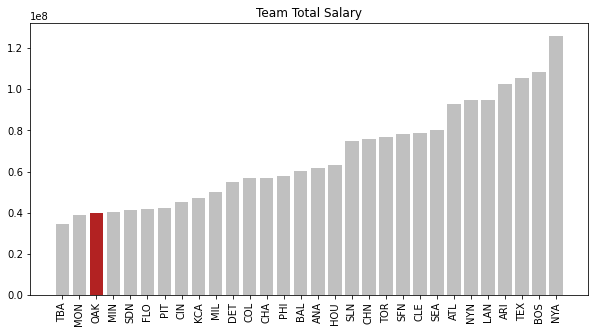

In [5]:
team_salary = df_salaries[df_salaries.yearID == 2002][['teamID','salary']].groupby('teamID').sum().sort_values(by=['salary'])
colors = ['firebrick' if i == 'OAK' else 'silver' for i in team_salary.index]
plt.figure(figsize=(10,5))
plt.title('Team Total Salary')
plt.bar(team_salary.index, team_salary.salary, color=colors)
plt.xticks(rotation=90)
plt.show()

### Replacing Key Players

The A's also needed to replace their key star players, Johnny Damon(CF) and **Jason Giambi(1B)** who is leaving the team.

In [6]:
# Let's see the batting average and at bat per homerun 
# of these three players in the previous season.
a = df_batting[(df_batting.yearID == 2001)].copy()
batting = a[['playerID','teamID','ABHR','AVG','OBP','SLG','OPS']]
player = df_player[['playerID','nameFirst','nameLast']]

# # At Bat per Homerun
# batting['ABHR'] = round(a['AB'] / a['HR'],3)

# AVG (H/AB)
# batting['AVG'] = round(a['H'] / a['AB'],3)

# salaries
batting = batting.merge(df_salaries[df_salaries.yearID==2002],
                        how='left',on='playerID')

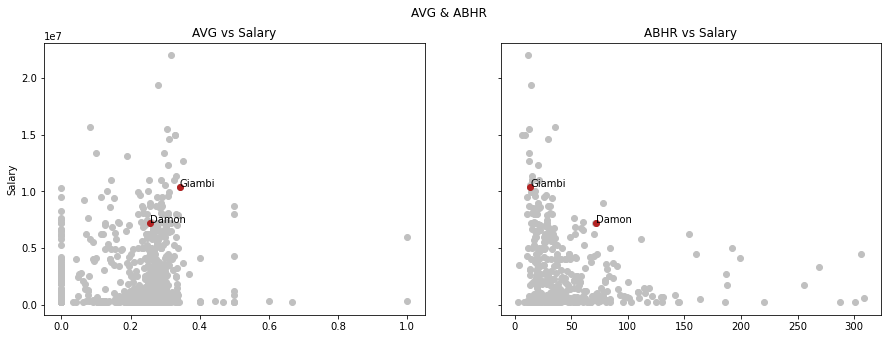

In [7]:
# batting = batting[batting.ABHR != np.inf]
batting = batting.dropna()
f,ax = plt.subplots(1,2,figsize=(15,5))
plt.suptitle('AVG & ABHR')
ax[0].set_title('AVG vs Salary')
ax[1].set_title('ABHR vs Salary')
ax[0].set_ylabel('Salary')
ax[1].label_outer()
ax[0].scatter(batting.AVG, batting.salary, color='silver')
ax[1].scatter(batting.ABHR, batting.salary, color='silver')

key = ['damonjo01','giambja01']
batting_key = batting[batting.playerID.isin(key)]
ax[0].scatter(batting_key.AVG, batting_key.salary, color='firebrick')
ax[1].scatter(batting_key.ABHR, batting_key.salary, color='firebrick')

names = ['Damon', 'Giambi']
for i, col in enumerate(['AVG','ABHR']):
    for j, name in enumerate(names):
        ax[i].annotate(name,(batting_key[col].values[j], batting_key.salary.values[j]))
    
plt.show()

Batting average and homerun rates were 2 important feature that evaluated batter's performance during the period and was over valued. Thus, the Oakland A's could not afford high priced homerun hitters with high batting average like Giambi and Damon

So, the question is rewritten:

- How do we make a team that can get to the playoffs with limited budget?

### Wins / Runs to Playoff

**"Your goal shouldn't be to buy players. Your goal should be to buy wins and in order to buy wins, you need to buy runs."**


Objective of Beane and DePodesta for Oakland A's was to make it to the playoffs and to make it to the playoffs, they needed alot of wins and to make wins they needed runs.

Beane and DePodestas' predicted that they needed approximately 95 wins to be qualified for the playoffs.

In [8]:
# create feature post
# made to playoff = 1
df_post = df_post[['yearID','teamID']]
df_post = df_post.drop_duplicates(subset=['yearID','teamID'], keep='first')
df_post['post'] = 1
# merge with team database
df_team = df_team[['yearID','teamID','W','L','R','RA','AVG','ABHR','OBP','SLG','OPS']]
df_team = df_team.merge(df_post, how='left',on=['yearID','teamID'])
df_team = df_team.fillna(0)

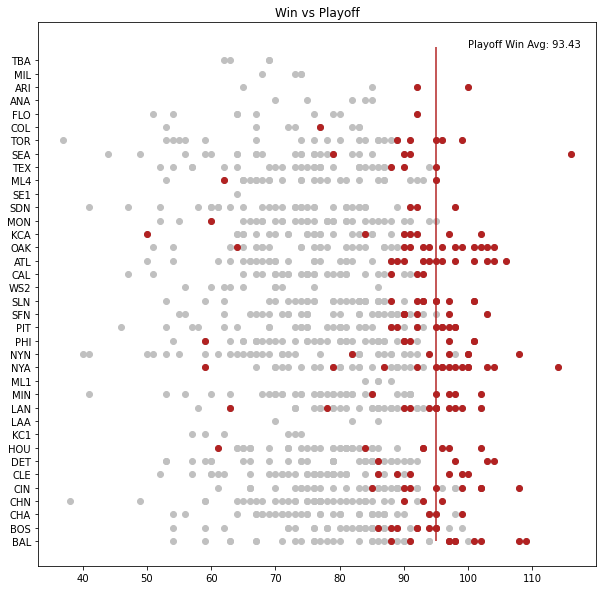

In [9]:
# It is known that DePodesta used data from 1962 to 2001
a = df_team[(df_team.yearID >= 1962)&(df_team.yearID <= 2001)].copy()
b = a[a.post == 1]
plt.figure(figsize=(10,10))
plt.title('Win vs Playoff')
plt.scatter(a.W, a.teamID, color='silver')
plt.scatter(b.W, b.teamID, color='firebrick')

# 95 wins line
plt.vlines(95,0,a.teamID.nunique(),color='firebrick')
plt.text(100, a.teamID.nunique(), f'Playoff Win Avg: {round(b.W.mean(),2)}')
plt.show()

We can see that the mean of the wins for those who made it to the playoffs is close to 95. Considering the outliers(teams that made it to the playoffs with few wins) that we will discuss later, it seems to be accurate. 

In [10]:
rd = df_team['R'] - df_team['RA']
df_team.insert(6, 'RD', rd)

In [11]:
a = df_team[(df_team.yearID >= 1962)&(df_team.yearID <= 2001)].copy()
X = a.W.values.reshape(-1,1)
y = a.RD.values.reshape(-1,1)

lr = LinearRegression()
lr = lr.fit(X,y)
print(f'coef: {lr.coef_[0][0]}\nintercept: {lr.intercept_[0]}')
print('R2:', lr.score(X,y))

coef: 6.517123071879459
intercept: -516.0682178545817
R2: 0.6851600019759458


In [12]:
# prediction for RD needed for 95 wins
result = round(lr.predict([[95]])[0][0],2)
print('RD needed for 95 Wins: ',result)

RD needed for 95 Wins:  103.06


DePodesta predicted that they needed 135 RD(Run Difference) to get 95 wins, but according to our model, it seems to be quite off and shows relatively low $R^2$ score.

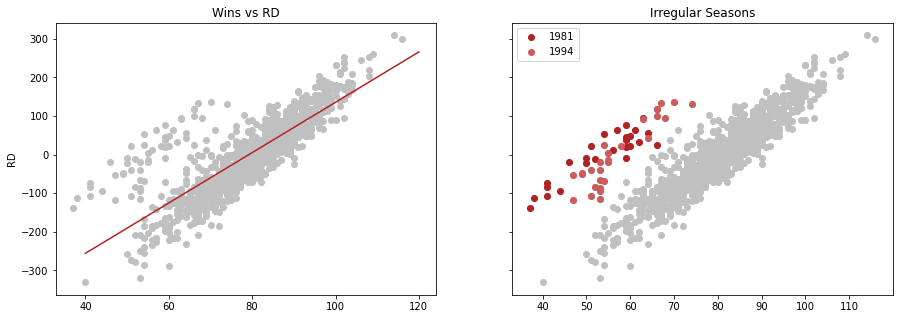

In [13]:
coef = lr.coef_[0][0]
inter = lr.intercept_[0]
a1981 = a[a.yearID == 1981]
a1994 = a[a.yearID == 1994]

f,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].set_title('Wins vs RD')
ax[1].set_title('Irregular Seasons')
ax[0].set_ylabel('RD')
ax[1].label_outer()

ax[0].scatter(a.W, a.RD, color='silver')
ax[0].plot([40,120], [coef*40+inter, coef*120+inter], color='firebrick')

ax[1].scatter(a.W, a.RD, color='silver')
ax[1].scatter(a1981.W, a1981.RD, color='firebrick', label='1981')
ax[1].scatter(a1994.W, a1994.RD, color='indianred', label='1994')

ax[1].legend()
plt.show()

As you can see from the plot, 1981 and 1994 season observations are out of the pile.

It turned out that there were Major League Baseball Strikes in 1981 and 1994, which shortened the seasons.

In [14]:
# drop 1981 and 1994 seasons
a = a[a.yearID.isin([1981,1994])==False]
X = a.RD.values.reshape(-1,1)
y = a.W.values.reshape(-1,1)

lr = LinearRegression()
lr = lr.fit(X,y)
print(f'coef: {lr.coef_[0][0]}\nintercept: {lr.intercept_[0]}')
print('R2:', lr.score(X,y))

result = round(lr.predict([[135]])[0][0],2)
print('Wins from 135 RD: ',result)

coef: 0.10541204175996782
intercept: 80.53668763102725
R2: 0.8608294714878817
Wins from 135 RD:  94.77


Now, it looks accurate!

And our model looks like:

    Wins ~ 80.5367 + 0.1054(RD)

### OBP and SLG

In [33]:
oak_01 = df_team[(df_team.yearID == 2001) & (df_team.teamID=='OAK')]
print('Oakland A\'s 2001 Season RD: ', oak_01.RD.values[0])

Oakland A's 2001 Season RD:  239


Oakland A's, in their previous season, were a strong team that made it to the playoffs with run difference of 239 runs. Thus, they just needed to replace their key players who can perform the same. Batting average and homeruns were the indicators that was used to evaluate batters performance. However, those with high batting average and homerun rates were expensive.

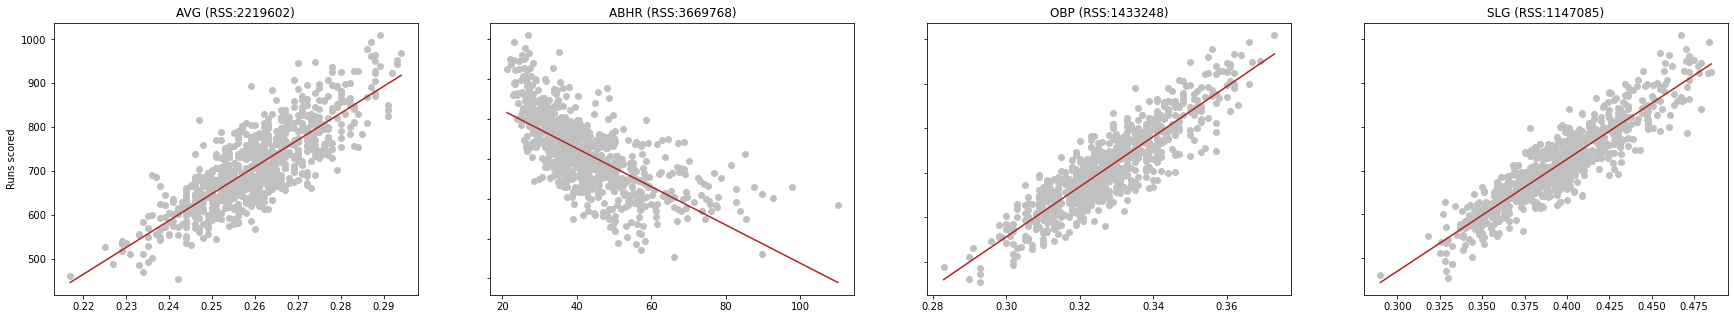

In [40]:
# HBP, stat that is needed for calculating OBP,
# started recording from the year 1970
year = np.arange(1970,2002)
a = df_team[df_team.yearID.isin(year)]
a = a[a.yearID.isin([1981,1994])==False]
cols = ['AVG','ABHR','OBP','SLG']

f,ax = plt.subplots(1,4,figsize=(30,5))
ax[0].set_ylabel('Runs scored')

for i,col in enumerate(cols):
    X = a[col].values.reshape(-1,1)
    y = a['R'].values.reshape(-1,1)
    min = a[col].min()
    max = a[col].max()
    lr = LinearRegression()
    lr = lr.fit(X,y)
    coef = lr.coef_[0][0]
    inter = lr.intercept_[0]
    rss = round(np.sum(np.square(y - lr.predict(X))))
    ax[i].scatter(a[col], a.R, color='silver')
    ax[i].plot([min,max], [coef*min+inter, coef*max+inter], color='firebrick')
    ax[i].set_title(f'{col} (RSS:{rss})')
    ax[i].label_outer()

plt.show()

We can see that out of the 4 features(AVG, ABHR, OBP, SLG), OBP and SLG have the lowest RSS(residual sum of squares) in predicting runs, which tells us that OBP and SLG are better predictor than the other two.

### Backward Elimination (finding the best combination)

In [41]:
smf.ols(formula='R ~ AVG + ABHR + OBP + SLG', data=a).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      R   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     1757.
Date:                Mon, 13 Jun 2022   Prob (F-statistic):               0.00
Time:                        14:41:17   Log-Likelihood:                -3784.8
No. Observations:                 790   AIC:                             7580.
Df Residuals:                     785   BIC:                             7603.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -818.0155     29.880    -27.377      0.000    -876.670    -759.361
AVG         -128.7253    215.781     -0.597      0.551    -552.302     294.851
ABHR          -0.0155      0.181     -0.086      0.931      -0.370       0.339
OBP         2869.6184    143.078     20.056      0.000    2588.758    3150.478
SLG         1581.5930    111.729     14.156      0.000    1362.271    1800.915
==============================================================================
Omnibus:                       47.639   Durbin-Watson:                   1.406
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.937
Skew:                          -0.498   Prob(JB):                     1.77e-15
Kurtosis:                       4.036   Cond. No.                     1.03e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
# Backward Elimination
values = ['AVG','ABHR','OBP','SLG']
elimination = True
while elimination == True:
    formula = ' + '.join(values)
    fit = smf.ols(formula = f'R ~ {formula}', data=a).fit()

    if fit.pvalues.sort_values(ascending=False)[0] > 0.15:
        val = fit.pvalues.sort_values(ascending=False).index[0]
        values.remove(val)

    else:
        elimination = False

smf.ols(formula = f'R ~ {formula}', data=a).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      R   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     3520.
Date:                Mon, 13 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:09:35   Log-Likelihood:                -3785.1
No. Observations:                 790   AIC:                             7576.
Df Residuals:                     787   BIC:                             7590.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -826.5491     25.698    -32.164      0.000    -876.993    -776.105
OBP         2805.0036    118.728     23.625      0.000    2571.942    3038.065
SLG         1570.2592     52.525     29.895      0.000    1467.153    1673.365
==============================================================================
Omnibus:                       46.614   Durbin-Watson:                   1.407
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.923
Skew:                          -0.492   Prob(JB):                     4.84e-15
Kurtosis:                       4.017   Cond. No.                         139.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
X = a[['OBP','SLG']].values
y = a['R'].values.reshape(-1,1)

lr = LinearRegression()
lr = lr.fit(X,y)
print(f'coef: {lr.coef_[0]}\nintercept: {lr.intercept_[0]}')
print('R2:', lr.score(X,y))

coef: [2805.00358283 1570.25916633]
intercept: -826.5490761664951
R2: 0.8994482867050713


        Runs Scored ~ -826.5491 + 2805.0036(OBP) + 1570.2592(SLG)

The A's also found out that OBP and SLG were significantly more important than other stats when predicting runs.

### OPS and SLG to prediction (Oakland A's 2002 Season)

In [43]:
# get rosters from 2002
roster = df_batting[df_batting.yearID == 2002][df_batting.teamID == 'OAK'].dropna()
# relate stats from prev season
prev = df_batting[df_batting.yearID == 2001][df_batting['playerID'].isin(roster.playerID)]
cols = ['H','BB','HBP','AB','SF','1B','2B','3B','HR']
stats = []
for i in cols:
    stats.append(prev[i].sum())

stats = pd.DataFrame(stats, index=cols).T
stats.pipe(add_feature)
stats

,H,BB,HBP,AB,SF,1B,2B,3B,HR,ABHR,AVG,OBP,SLG,OPS
0,1632.0,646.0,89.0,6277.0,59.0,1022.0,356.0,29.0,225.0,27.898,0.26,0.335,0.433,0.768


Suppose that players from 2002 season will perform similarly to 2001 season. Then the Oakland A's will get **SLG** of **0.433** and **OBP** of **0.335**.

By applying the result to our Runs Scored Equation:

      Runs Scored ~ -826.5491 + 2805.0036(0.355) + 1570.2592(0.433) ~ 849

In [44]:
x = [[0.355, 0.433]]
result = lr.predict(x)
print(f'Expected Runs Score: {round(result[0][0])}')

Expected Runs Score: 849


For RA, pitcher's runs allowed from the previous season are used.

In [45]:
# get rosters from 2002
roster_pitcher = df_pitching[df_pitching.yearID == 2002][df_pitching.teamID == 'OAK']
# relate stats from prev season
prev = df_pitching[df_pitching.yearID == 2001][df_pitching['playerID'].isin(roster_pitcher.playerID)]

stats_pitcher = prev.R.sum()
print(f'Expected Runs Allow: {stats_pitcher}')

Expected Runs Allow: 688


        Expected Runs Difference = 849 - 688 = 161

        Wins ~ 80.5367 + 0.1054(161) 

After implying the RD to our wins prediction equation, we got the result of **98 wins**, which is pretty close to the actual result, 103 wins. 

It looks like our OBP and SLG used model is accurate.

### Replacing Players

The market price for SLG and OBP were under valued and now that we know OBP and SLG are two important features to predict runs, lets replace giambi and damon with these two stats.

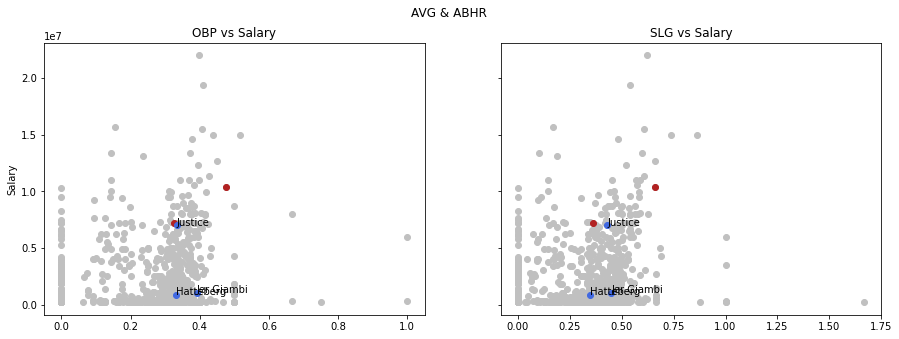

In [46]:
# batting = batting[batting.ABHR != np.inf]
batting = batting.dropna()
f,ax = plt.subplots(1,2,figsize=(15,5))
plt.suptitle('AVG & ABHR')
ax[0].set_title('OBP vs Salary')
ax[1].set_title('SLG vs Salary')
ax[0].set_ylabel('Salary')
ax[1].label_outer()
ax[0].scatter(batting.OBP, batting.salary, color='silver')
ax[1].scatter(batting.SLG, batting.salary, color='silver')

# damon and giambi
key = ['damonjo01','giambja01']
batting_key = batting[batting.playerID.isin(key)]
ax[0].scatter(batting_key.OBP, batting_key.salary, color='firebrick')
ax[1].scatter(batting_key.SLG, batting_key.salary, color='firebrick')

# replacement (Jeremy Giambi, Hatteberg, Justice)
repl = ['giambje01','hattesc01','justida01']
batting_repl = batting[batting.playerID.isin(repl)]
ax[0].scatter(batting_repl.OBP, batting_repl.salary, color='royalblue')
ax[1].scatter(batting_repl.SLG, batting_repl.salary, color='royalblue')

names = ['Jer Giambi','Hatteberg','Justice']
for i, col in enumerate(['OBP','SLG']):
    for j, name in enumerate(names):
        ax[i].annotate(name,(batting_repl[col].values[j], batting_repl.salary.values[j]))
    
plt.show()

The sum of OBP of Giambi and Damon + Olmendo, who seems to be a free agent also with OBP 0.291, is 1.092. To replace them, the A's signs undervalued players such as Jeremy Giambi and Scott Hatteberg with batting average of 0.2xx.

However, the sum of OBP for these three players were 1.056.

- The A's were able to get Justice for half of the salary from the plot. The New York Mets were willing to pay the half to get him away. So, the actual price should be cheaper than it is shown in the plot.

And thats it!!